<a href="https://colab.research.google.com/github/RishabhL7/Pubnew/blob/main/Copy_of_Linkmobsam_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import cv2
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
import keras
from tqdm import tqdm
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

from tensorflow.keras import backend as K
from tensorflow.keras.layers import *

from tensorflow.keras.layers import Conv2D, Activation, BatchNormalization
from tensorflow.keras.layers import UpSampling2D, Input, Concatenate, Conv2DTranspose, Add, AveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras import models
from tensorflow.keras import backend as K
from tensorflow.python.keras.utils import generic_utils

In [2]:
!pip install segmentation_models
import segmentation_models as sm
sm.set_framework('tf.keras')
sm.framework()

     |████████████████████████████████| 50 kB 8.0 MB/s 
Segmentation Models: using `keras` framework.


'tf.keras'

In [3]:
!pip install git+https://github.com/qubvel/classification_models.git
from classification_models.keras import Classifiers

  Cloning https://github.com/qubvel/classification_models.git to /tmp/pip-req-build-f2vyx2_s
  Running command git clone -q https://github.com/qubvel/classification_models.git /tmp/pip-req-build-f2vyx2_s
  Running command git submodule update --init --recursive -q


In [4]:
!nvidia-smi

Sat Jan 15 10:37:04 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.46       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [5]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [6]:
!unzip '/content/drive/MyDrive/Data.zip'

Streaming output truncated to the last 5000 lines.
 extracting: Data/hand_data_test/segmentation/A-aha-0004.png  
 extracting: Data/hand_data_test/segmentation/A-aha-0005.png  
 extracting: Data/hand_data_test/segmentation/A-aha-0006.png  
 extracting: Data/hand_data_test/segmentation/A-aha-0007.png  
 extracting: Data/hand_data_test/segmentation/A-aha-0008.png  
 extracting: Data/hand_data_test/segmentation/A-aha-0009.png  
 extracting: Data/hand_data_test/segmentation/A-aha-0010.png  
 extracting: Data/hand_data_test/segmentation/A-apa-0001.png  
 extracting: Data/hand_data_test/segmentation/A-apa-0002.png  
 extracting: Data/hand_data_test/segmentation/A-apa-0003.png  
 extracting: Data/hand_data_test/segmentation/A-apa-0004.png  
 extracting: Data/hand_data_test/segmentation/A-apa-0005.png  
 extracting: Data/hand_data_test/segmentation/A-apa-0006.png  
 extracting: Data/hand_data_test/segmentation/A-apa-0007.png  
 extracting: Data/hand_data_test/segmentation/A-apa-0008.png  
 ext

In [7]:
IMG_WIDTH = 320
IMG_HEIGHT = 320
IMG_CHANNELS = 3

In [8]:
np.random.seed(42)

In [9]:
path = "/content/Data/hand_data_train/colour"
maskpath = "/content/Data/hand_data_train/segmentation"

X_train = np.zeros((len(os.listdir(path)), IMG_HEIGHT, IMG_WIDTH,IMG_CHANNELS),dtype=np.uint8)
Y_train = np.zeros((len(os.listdir(maskpath)), IMG_HEIGHT, IMG_WIDTH,1))
print('creating input data')
n=0
for name in tqdm(os.listdir(path)):
    newpath = os.path.join(path,name)
    img=cv2.imread(newpath)
    img=cv2.resize(img,(IMG_WIDTH,IMG_HEIGHT))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    X_train[n]=img
    n+=1

m=0
for name in tqdm(os.listdir(maskpath)):
    newmaskpath = os.path.join(maskpath,name)
    mpg=cv2.imread(newmaskpath,0)
    mpg=cv2.resize(mpg,(IMG_WIDTH,IMG_HEIGHT))
    mpg=np.expand_dims(mpg,axis=-1)
    Y_train[m]=mpg/255
    m+=1

creating input data


100%|██████████| 2000/2000 [00:02<00:00, 702.10it/s]


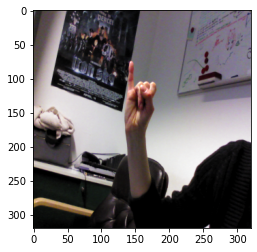

In [10]:
plt.imshow(array_to_img(X_train[0]))

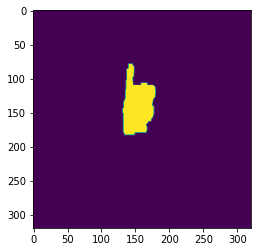

In [11]:
plt.imshow(array_to_img(Y_train[0]))

In [12]:
smooth = 1e-15
def dice_coef(y_true, y_pred):
    y_true = tf.keras.layers.Flatten()(y_true)
    y_pred = tf.keras.layers.Flatten()(y_pred)
    intersection = tf.reduce_sum(y_true * y_pred)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + smooth)
    
def dice_loss(y_true, y_pred):
    return 1.0 - dice_coef(y_true, y_pred)

In [13]:
def sa_block(inputs):
    """
    Spatial Attention Module utilizing the inter-spatial relationship of features.
    """
    kernel_size = 3

    # avg_pool = Lambda(lambda x: K.mean(x, axis=-1, keepdims=True))(inputs)
    # max_pool = Lambda(lambda x: K.max(x, axis=-1, keepdims=True))(inputs)
    avg_pool = K.mean(inputs, axis=-1, keepdims=True)
    max_pool = K.max(inputs, axis=-1, keepdims=True)

    x = Concatenate()([avg_pool, max_pool])

    x = Conv2D(1, kernel_size, padding='same', activation='sigmoid', kernel_initializer='he_normal', use_bias=False)(x)

    outputs = Multiply()([inputs, x])
    return outputs

In [14]:
def ASPP(inputs):

    conv_filters = 64
    """ Image Pooling """
    shape = inputs.shape
    y1 = AveragePooling2D(pool_size=(shape[1], shape[2]))(inputs)
    y1 = Conv2D(conv_filters, 1, padding="same", use_bias=False)(y1)
    y1 = BatchNormalization()(y1)
    y1 = Activation("relu")(y1)
    y1 = UpSampling2D((shape[1], shape[2]), interpolation="bilinear")(y1)

    """ 1x1 conv """
    y2 = Conv2D(conv_filters, 1, padding="same", use_bias=False)(inputs)
    y2 = BatchNormalization()(y2)
    y2 = Activation("relu")(y2)

    """ 3x3 conv rate=6 """
    y3 = Conv2D(conv_filters, 3, padding="same", use_bias=False, dilation_rate=6)(inputs)
    y3 = BatchNormalization()(y3)
    y3 = Activation("relu")(y3)

    """ 3x3 conv rate=12 """
    y4 = Conv2D(conv_filters, 3, padding="same", use_bias=False, dilation_rate=12)(inputs)
    y4 = BatchNormalization()(y4)
    y4 = Activation("relu")(y4)

    """ 3x3 conv rate=18 """
    y5 = Conv2D(conv_filters, 3, padding="same", use_bias=False, dilation_rate=18)(inputs)
    y5 = BatchNormalization()(y5)
    y5 = Activation("relu")(y5)

    y = Concatenate()([y1, y2, y3, y4, y5])
    y = Conv2D(conv_filters, 1, padding="same", use_bias=False)(y)
    y = BatchNormalization()(y)
    y = Activation("relu")(y)

    return y

In [15]:
def build_LinkNet_mobilenetv2():  
  model = tf.keras.applications.MobileNetV2(input_shape=(320, 320,3), include_top=False, weights="imagenet")

  """ Skip Connections """

  s1 = model.get_layer("block_1_expand_relu").output         ## (160, 160)
  s1 = sa_block(s1)
  s2 = model.get_layer("block_3_expand_relu").output         ## ( 80, 80)
  s2 = sa_block(s2)
  s3 = model.get_layer("block_6_expand_relu").output         ## (40, 40)
  s3 = sa_block(s3)
  s4 = model.get_layer("block_13_expand_relu").output         ## (20, 20)
  s4 = sa_block(s4)

  #print(s1.shape, s2.shape, s3.shape, s4.shape)

  """ Bridge """

  b1 = model.get_layer("out_relu").output
  b1 = ASPP(b1)
  #print(b1.shape)

  """ Decoder """
  x = Conv2D(320, (1,1), kernel_initializer='he_normal', padding = 'same')(b1)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)

  x = tf.keras.layers.UpSampling2D( size=(2, 2), interpolation='nearest')(x)

  x = Conv2D(320, (3,3), kernel_initializer='he_normal', padding = 'same')(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)

  x = Conv2D(576, (1,1), kernel_initializer='he_normal', padding = 'same')(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)

  x = Add()([x, s4]) # ADD 1

  x = Conv2D(144, (1,1), kernel_initializer='he_normal', padding = 'same')(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)

  x = tf.keras.layers.UpSampling2D( size=(2, 2), interpolation='nearest')(x)

  x = Conv2D(144, (3,3), kernel_initializer='he_normal', padding = 'same')(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)

  x = Conv2D(192, (1,1), kernel_initializer='he_normal', padding = 'same')(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)

  x = Add()([x, s3]) # ADD 2

  x = Conv2D(48, (1,1), kernel_initializer='he_normal', padding = 'same')(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)

  x = tf.keras.layers.UpSampling2D( size=(2, 2), interpolation='nearest')(x)

  x = Conv2D(48, (3,3), kernel_initializer='he_normal', padding = 'same')(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)

  x = Conv2D(144, (1,1), kernel_initializer='he_normal', padding = 'same')(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)

  x = Add()([x, s2]) # ADD 3

  x = Conv2D(36, (1,1), kernel_initializer='he_normal', padding = 'same')(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)

  x = tf.keras.layers.UpSampling2D( size=(2, 2), interpolation='nearest')(x)

  x = Conv2D(36, (3,3), kernel_initializer='he_normal', padding = 'same')(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)

  x = Conv2D(96, (1,1), kernel_initializer='he_normal', padding = 'same')(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)

  x = Add()([x, s1]) # ADD 4

  x = Conv2D(24, (1,1), kernel_initializer='he_normal', padding = 'same')(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)

  x = tf.keras.layers.UpSampling2D( size=(2, 2), interpolation='nearest')(x)

  x = Conv2D(24, (3,3), kernel_initializer='he_normal', padding = 'same')(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)

  x = Conv2D(16, (1,1), kernel_initializer='he_normal', padding = 'same')(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)

  outputs = Conv2D(1, 1, kernel_initializer='he_normal',padding="same")(x)
  outputs = Activation('sigmoid')(outputs)

  model = keras.models.Model(inputs=[model.input], outputs=[outputs])  

  #print(model.summary())

  return model

In [16]:
model = build_LinkNet_mobilenetv2()
model.summary()

9420800/9406464 [==============================] - 0s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 320, 320, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 160, 160, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 160, 160, 32  128         ['Conv1[0][0]']                  
                               

In [17]:
from tensorflow.keras.optimizers import Adam
model.compile(loss=dice_loss, optimizer=Adam(1e-4), metrics=["accuracy"])

In [18]:
path = "/content/drive/MyDrive/Colab Notebooks/Checkpoints_main/aspptry_11"
os.mkdir(path)
checkpoint_path_segmentdeeplab = "/content/drive/MyDrive/Colab Notebooks/Checkpoints_main/aspptry_11/cp.ckpt"
model_checkpoint_segmentdeeplab = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path_segmentdeeplab,
                                                 save_weights_only=True,
                                                  monitor='val_accuracy',save_best_only=True,
                                                 verbose=1)

In [19]:
history = model.fit(X_train,Y_train,validation_split = 0.1,batch_size=8,epochs=12,callbacks=[model_checkpoint_segmentdeeplab])

Epoch 1/12
225/225 [==============================] - ETA: 0s - loss: 0.5522 - accuracy: 0.8939
Epoch 00001: val_accuracy improved from -inf to 0.93361, saving model to /content/drive/MyDrive/Colab Notebooks/Checkpoints_main/aspptry_11/cp.ckpt
225/225 [==============================] - 61s 202ms/step - loss: 0.5522 - accuracy: 0.8939 - val_loss: 0.5012 - val_accuracy: 0.9336
Epoch 2/12
225/225 [==============================] - ETA: 0s - loss: 0.4100 - accuracy: 0.9714
Epoch 00002: val_accuracy improved from 0.93361 to 0.97315, saving model to /content/drive/MyDrive/Colab Notebooks/Checkpoints_main/aspptry_11/cp.ckpt
225/225 [==============================] - 44s 197ms/step - loss: 0.4100 - accuracy: 0.9714 - val_loss: 0.3917 - val_accuracy: 0.9731
Epoch 3/12
225/225 [==============================] - ETA: 0s - loss: 0.3521 - accuracy: 0.9780
Epoch 00003: val_accuracy improved from 0.97315 to 0.98030, saving model to /content/drive/MyDrive/Colab Notebooks/Checkpoints_main/aspptry_11/cp

In [20]:
path = "/content/Data/hand_data_test/colour"
maskpath = "/content/Data/hand_data_test/segmentation"

X_test = np.zeros((len(os.listdir(path)), IMG_HEIGHT, IMG_WIDTH,IMG_CHANNELS),dtype=np.uint8)
Y_test = np.zeros((len(os.listdir(maskpath)), IMG_HEIGHT, IMG_WIDTH,1))
print('creating test data')
n=0
for name in tqdm(os.listdir(path)):
    newpath = os.path.join(path,name)
    img=cv2.imread(newpath)
    img=cv2.resize(img,(IMG_WIDTH,IMG_HEIGHT))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    X_test[n]=img
    n+=1

m=0
for name in tqdm(os.listdir(maskpath)):
    newmaskpath = os.path.join(maskpath,name)
    mpg=cv2.imread(newmaskpath,0)
    mpg=cv2.resize(mpg,(IMG_WIDTH,IMG_HEIGHT))
    mpg=np.expand_dims(mpg,axis=-1)
    Y_test[m]=mpg/255
    m+=1

creating test data


100%|██████████| 1000/1000 [00:01<00:00, 602.99it/s]


In [21]:
!pip install sklearn
!pip install scipy

In [22]:
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from sklearn.metrics import f1_score

In [23]:
y_pred=model.predict(X_test)

In [24]:
## Jaccard Index ( IoU )

#y_pred=model.predict(X_test)
y_pred_thresholded = y_pred > 0.5

intersection = np.logical_and(Y_test, y_pred_thresholded)
union = np.logical_or(Y_test, y_pred_thresholded)
iou_score = np.sum(intersection) / np.sum(union)
print("IoU socre is: ", iou_score)

IoU socre is:  0.832847002464964


Text(0.5, 1.0, 'TEST IMAGE')

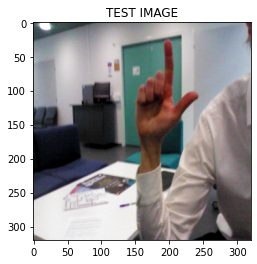

In [25]:
plt.imshow(array_to_img(X_test[7]))
plt.title('TEST IMAGE')

Text(0.5, 1.0, 'TEST SEGMENTATION MASK GROUND TRUTH')

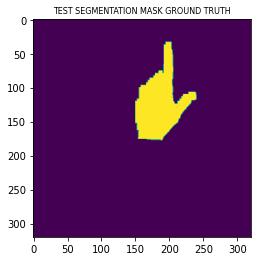

In [26]:
plt.imshow(array_to_img(Y_test[7]))
plt.title('TEST SEGMENTATION MASK GROUND TRUTH', fontsize=8)

Text(0.5, 1.0, 'TEST SEGMENTATION MASK OBTAINED FROM DEEP LEARNING MODULE')

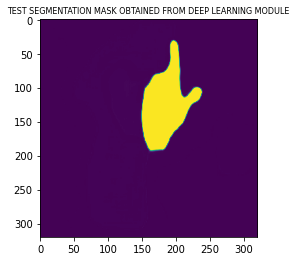

In [27]:
plt.imshow(array_to_img(y_pred[7]))
plt.title('TEST SEGMENTATION MASK OBTAINED FROM DEEP LEARNING MODULE', fontsize=8)

In [28]:
x_test_single = np.expand_dims(X_test[15], axis = 0)

In [29]:
import time
start_time = time.time()
y_single = model.predict(x_test_single)
print("--- %s seconds ---" % (time.time() - start_time))

--- 0.36257219314575195 seconds ---


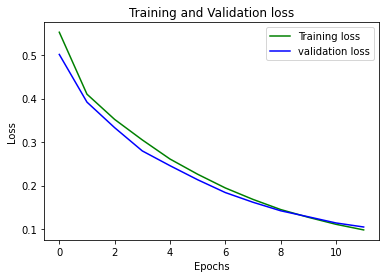

In [30]:
loss_train = history.history['loss']
loss_val = history.history['val_loss']
epochs = range(0,12)
plt.plot(epochs, loss_train, 'g', label='Training loss')
plt.plot(epochs, loss_val, 'b', label='validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

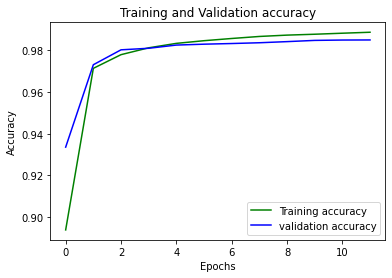

In [31]:
loss_train = history.history['accuracy']
loss_val = history.history['val_accuracy']
epochs = range(0,12)
plt.plot(epochs, loss_train, 'g', label='Training accuracy')
plt.plot(epochs, loss_val, 'b', label='validation accuracy')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()